In [1013]:
import os
import itertools
import warnings
from typing import Optional, List, Dict, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.easter import easter

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

warnings.filterwarnings("ignore", category=FutureWarning)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
FREQ = "W-MON"

In [1014]:
path_nat = '../data/processed/data_processed_v3_National_NoAcum_Total.csv'
df_national_raw = pd.read_csv(path_nat)
print(df_national_raw.head())
print()

path_states = '../data/processed/data_processed_v3_NoAcum_Total.csv'
df_states_raw = pd.read_csv(path_states)
print(df_states_raw.head())
print()

path_states_sex = '../data/processed/data_processed_v3_NoAcum_MF.csv'
df_states_sex_raw = pd.read_csv(path_states_sex)
print(df_states_sex_raw.head())

   Year  Week        Date  Epi_Year  New_Cases
0  2014     2  2014-01-13      2014       9.25
1  2014     3  2014-01-20      2014      29.00
2  2014     4  2014-01-27      2014      47.00
3  2014     5  2014-02-03      2014      35.50
4  2014     6  2014-02-10      2014      40.50

   Year  Week        Date          Entity  Epi_Year  total_cases
0  2014     2  2014-01-13  Aguascalientes      2014          0.0
1  2014     3  2014-01-20  Aguascalientes      2014          0.0
2  2014     4  2014-01-27  Aguascalientes      2014          0.0
3  2014     5  2014-02-03  Aguascalientes      2014          0.0
4  2014     6  2014-02-10  Aguascalientes      2014          0.0

   Year  Week        Date          Entity  Epi_Year    M    F
0  2014     2  2014-01-13  Aguascalientes      2014  0.0  0.0
1  2014     3  2014-01-20  Aguascalientes      2014  0.0  0.0
2  2014     4  2014-01-27  Aguascalientes      2014  0.0  0.0
3  2014     5  2014-02-03  Aguascalientes      2014  0.0  0.0
4  2014     6  2

In [1015]:
def _first_existing(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

def _standarize_ts_dfs(df, date_candidates = ["ds", "Date", "date"], target_candidates = ["y", "Total", "total_cases", "Total_Cases", "Cases", "cases", "New_Cases", "new_cases"]):
    # Will return df with cols ["ds", "y"] and sorted
    df2 = df.copy()
    dcol = _first_existing(df2.columns, date_candidates)
    ycol = _first_existing(df2.columns, target_candidates)
    if dcol is None:
        raise ValueError("No date column found")
    if ycol is None:
        raise ValueError("No target column found")
    df2 = df2.rename(columns={dcol: "ds", ycol: "y"})
    df2["ds"] = pd.to_datetime(df2["ds"]) 
    df2 = df2[["ds", "y"]].sort_values("ds").reset_index(drop=True)

    return df2[["ds", "y"]]


def build_state_dict(df_states_raw, entity_candidates=["State", "state", "Entidad", "entidad", "Entity"], date_candidates=["ds", "Date", "date"], target_candidates=["New_Cases", "Total", "total_cases", "Total_Cases", "Cases", "cases", "new_cases"]):
    # Returns 
    # dfs_state: {state: df[ds, y]}

    df = df_states_raw.copy()
    ecol = _first_existing(df.columns, entity_candidates)
    dcol = _first_existing(df.columns, date_candidates)
    tcol = _first_existing(df.columns, target_candidates)
    if ecol is None:
        raise ValueError(f"Cant find col entity in {entity_candidates}")
    if dcol is None:
        raise ValueError(f"Cant find col date in {date_candidates}")
    df[dcol] = pd.to_datetime(df[dcol])
    dfs_state = {}

    # For each state
    for st, sdf in df.groupby(ecol):
        # Will create another dictionary with [ds, y]
        tmp = sdf.rename(columns={dcol: "ds", tcol: "y"})[["ds", "y"]].sort_values("ds").copy()
        dfs_state[st] = tmp
    return dfs_state

def build_state_sex_dict(df_states_sex_raw, entity_candidates = ["State", "state", "Entidad", "entidad", "Entity"], date_candidates = ["ds", "Date", "date"], h_col = "M", m_col = "F"):
    # Returns 
    # dfs_state: {(state, sex): df[ds, y]}
    df = df_states_sex_raw.copy()
    ecol = _first_existing(df.columns, entity_candidates)
    dcol = _first_existing(df.columns, date_candidates)
    if ecol is None:
        raise ValueError(f"Cant find col entity in {entity_candidates}")
    if dcol is None:
        raise ValueError(f"Cant find col date in {date_candidates}")
    df[dcol] = pd.to_datetime(df[dcol])
    dfs_state_sex = {}

    for st, sdf in df.groupby(ecol):
        # H
        tmpH = sdf.rename(columns={dcol: "ds", h_col: "y"})[["ds", "y"]].sort_values("ds").copy()
        dfs_state_sex[(st, "M")] = tmpH
        # M
        tmpM = sdf.rename(columns={dcol: "ds", m_col: "y"})[["ds", "y"]].sort_values("ds").copy()
        dfs_state_sex[(st, "F")] = tmpM

    return dfs_state_sex
    

In [1016]:
# National
df_national = _standarize_ts_dfs(df_national_raw)

# States and State-Sex
dfs_state = build_state_dict(df_states_raw)
dfs_state_sex = build_state_sex_dict(df_states_sex_raw)

print("National DataFrame:")
print(df_national.head())
print()

print("State DataFrame (Aguascalientes):")
print(dfs_state['Aguascalientes'].head())
print()

print("State-Sex DataFrame (Aguascalientes, M):")
print(dfs_state_sex[('Aguascalientes', 'M')].head())
print()

National DataFrame:
          ds      y
0 2014-01-13   9.25
1 2014-01-20  29.00
2 2014-01-27  47.00
3 2014-02-03  35.50
4 2014-02-10  40.50

State DataFrame (Aguascalientes):
          ds    y
0 2014-01-13  0.0
1 2014-01-20  0.0
2 2014-01-27  0.0
3 2014-02-03  0.0
4 2014-02-10  0.0

State-Sex DataFrame (Aguascalientes, M):
          ds    y
0 2014-01-13  0.0
1 2014-01-20  0.0
2 2014-01-27  0.0
3 2014-02-03  0.0
4 2014-02-10  0.0



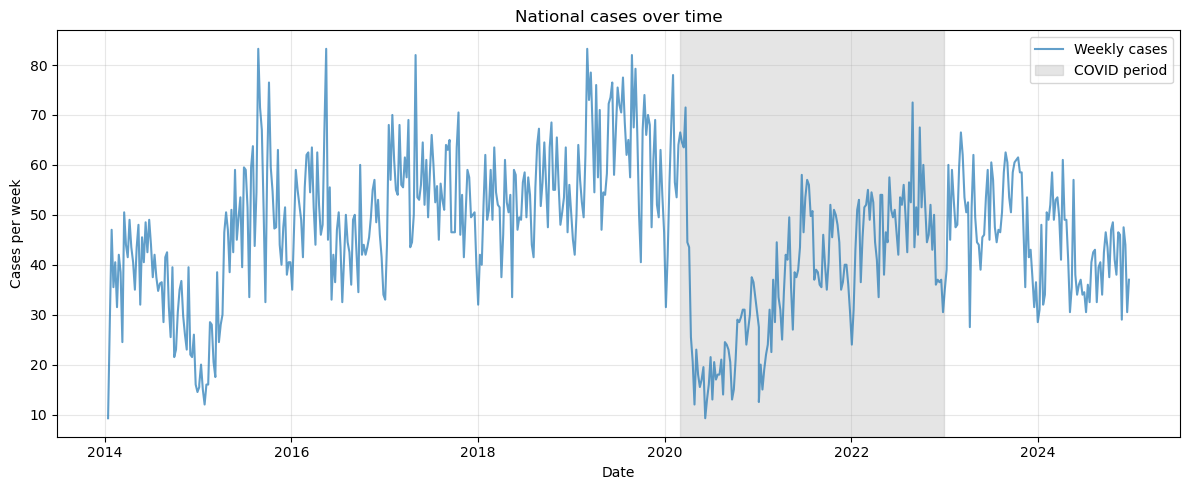

In [1017]:
# Plot national cases over time with a 4-week rolling average and COVID period highlight
plt.figure(figsize=(12,5))
plt.plot(df_national["ds"], df_national["y"], label="Weekly cases", alpha=0.7)
#plt.plot(df_national["ds"], df_national["y"].rolling(4, center=True).mean(), label="4-week MA", color="red", linewidth=2)

# highlight COVID period used in pipeline
cov_start = pd.Timestamp("2020-03-01")
cov_end = pd.Timestamp("2022-12-31")
plt.axvspan(cov_start, cov_end, color="gray", alpha=0.2, label="COVID period")

plt.xlabel("Date")
plt.ylabel("Cases per week")
plt.title("National cases over time")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

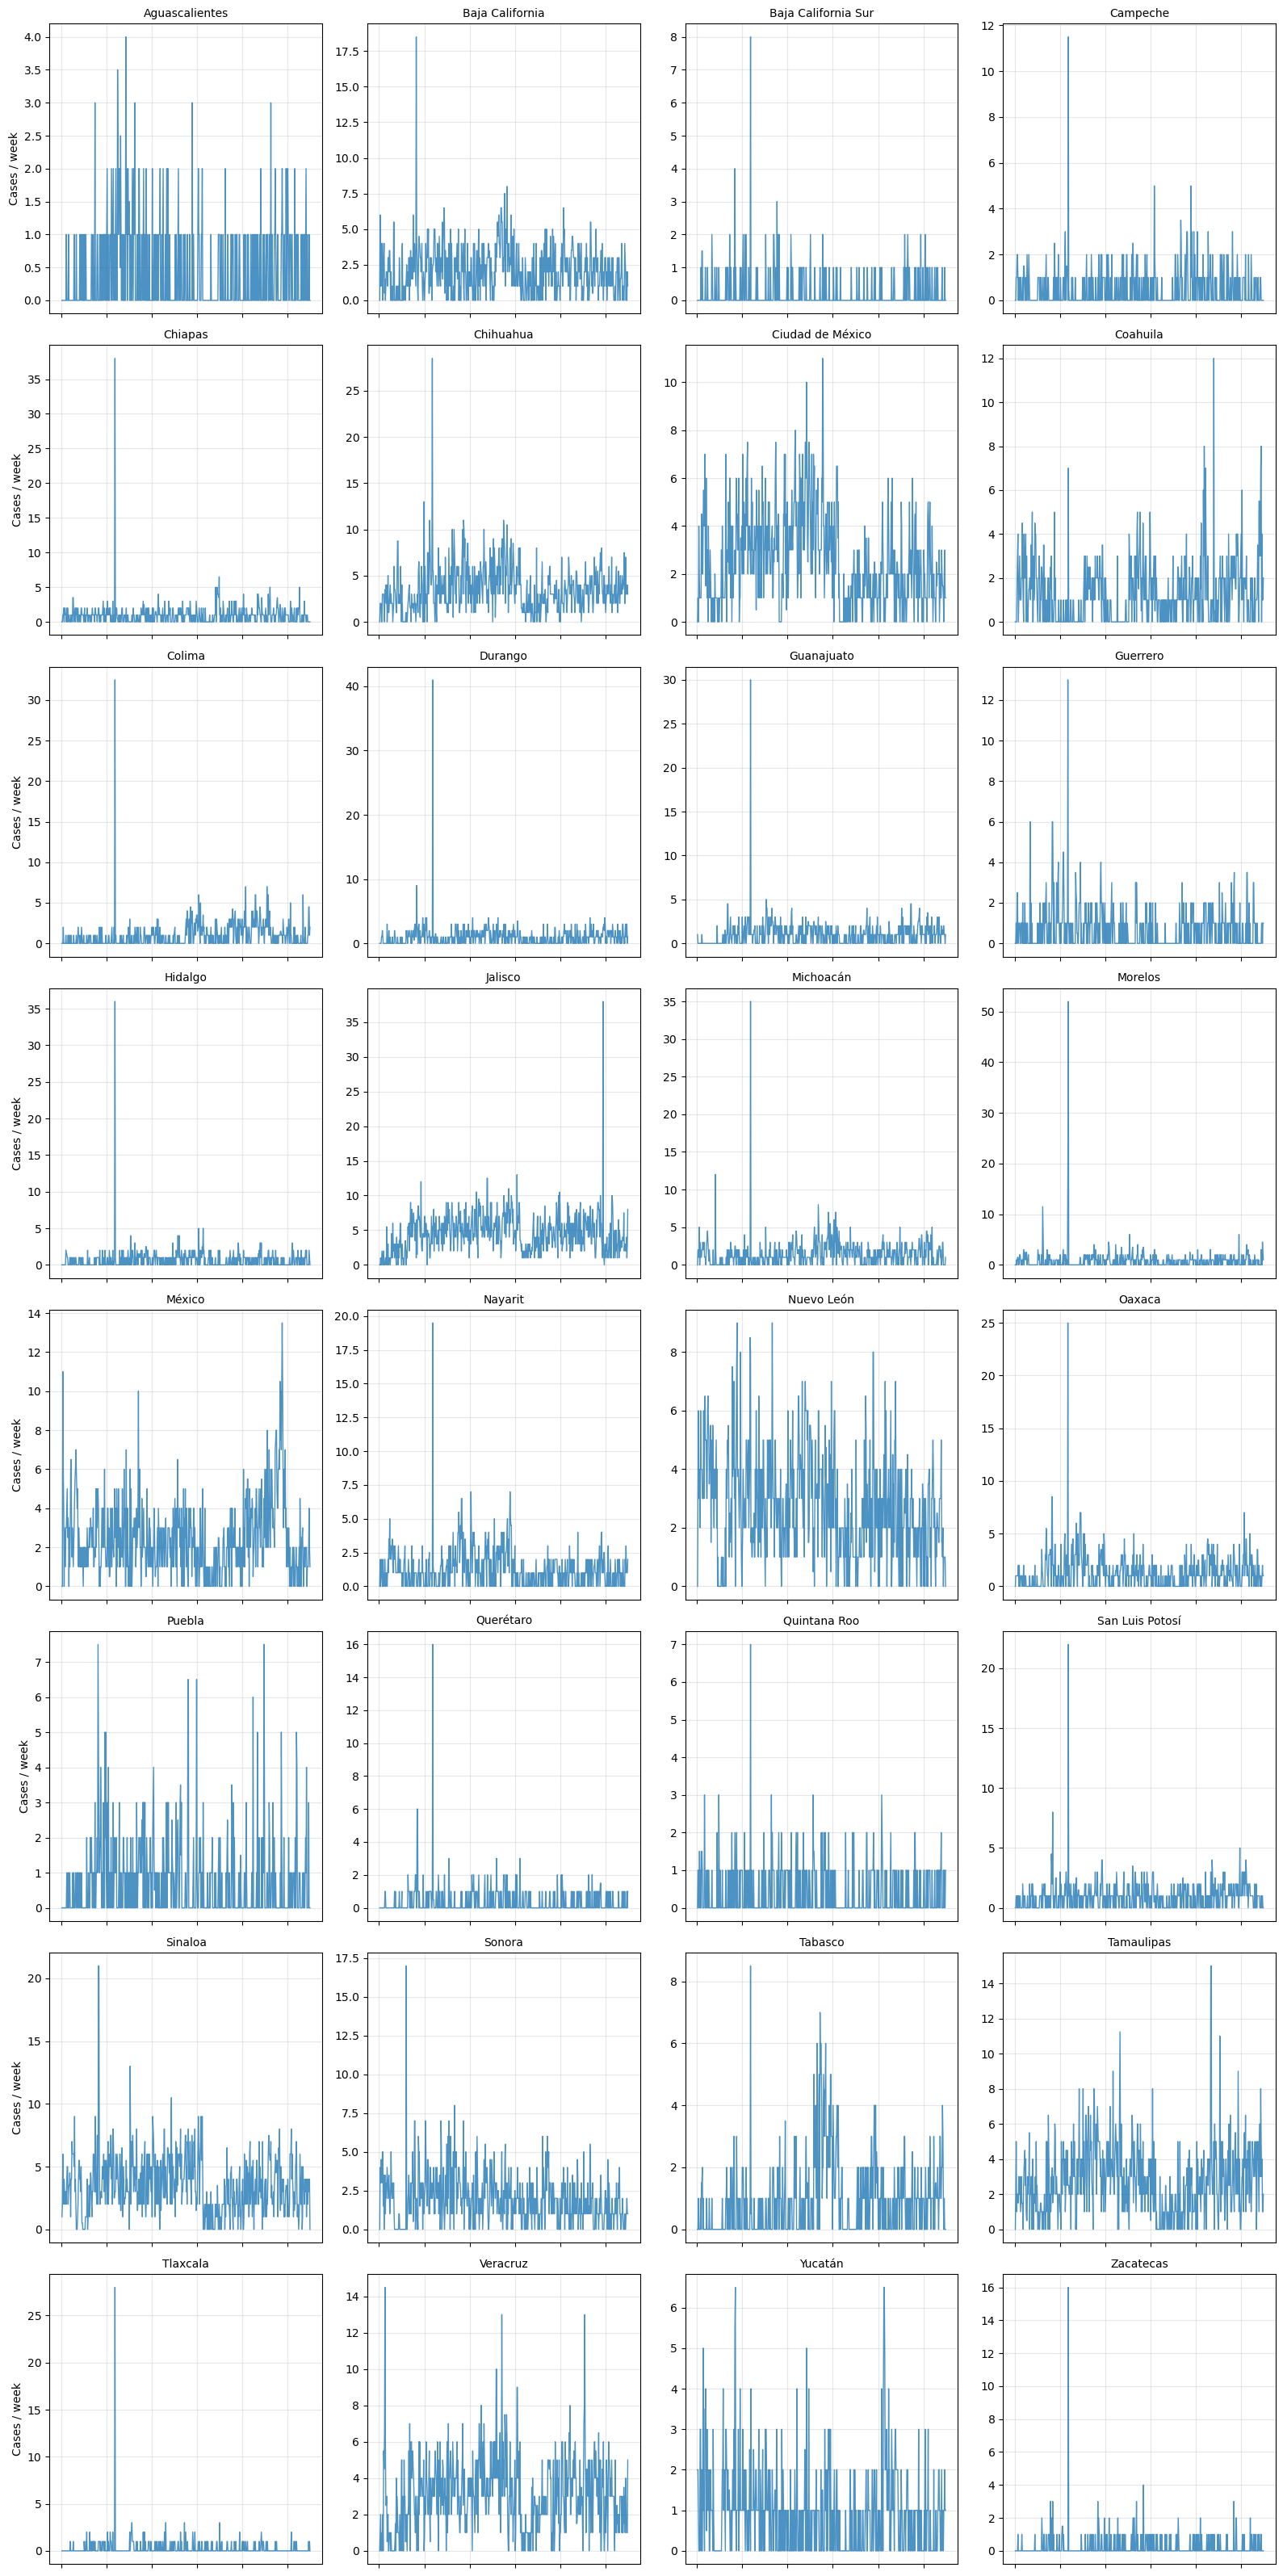

In [1018]:
# Plot 32 separate state-level time series (total cases over time)
states = state_names if 'state_names' in globals() else sorted(dfs_state.keys())

n_plots = len(states)
ncols = 4
nrows = int(np.ceil(n_plots / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows), sharex=True)
axes = axes.flatten()

for i, st in enumerate(states):
    ax = axes[i]
    df_st = dfs_state[st].sort_values("ds")
    ax.plot(df_st["ds"], df_st["y"], lw=1, alpha=0.8)
    ax.set_title(st, fontsize=10)
    ax.grid(alpha=0.3)
    # limit number of x-ticks for readability
    if i % ncols == 0:
        ax.set_ylabel("Cases / week")
    # rotate only bottom row xticks
    if i // ncols == nrows - 1:
        plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
    else:
        ax.set_xticklabels([])

# hide any unused subplots
for j in range(n_plots, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

Function that returns a DataFrame of holidays for years [start_year .. end_year].

Includes:
    holiday name (e.g., "Navidad", "Ano_Nuevo", "Semana_Santa")

This way we use the same holiday calendar consistently across all Prophet models (national, state, state-sex).

In [1019]:
def build_mex_holidays(start_year, end_year, semana_santa_window_days=7):
    rows = []
    for y in range(start_year, end_year + 1):
        rows.append({"ds": pd.Timestamp(f"{y}-12-25"), "holiday": "Navidad"})
        rows.append({"ds": pd.Timestamp(f"{y}-01-01"), "holiday": "Ano_Nuevo"})
        easter_date = pd.Timestamp(easter(y))
        rows.append({"ds": easter_date, "holiday": "Semana_Santa"})
    hol = pd.DataFrame(rows)
    mask = hol['holiday'] == 'Semana_Santa'
    hol.loc[mask, 'lower_window'] = -semana_santa_window_days
    hol.loc[mask, 'upper_window'] = semana_santa_window_days
    return hol

This is important for Prophet because COVID created an abnormal dip in recorded cases (under-reporting). The dummy lets the model separate that shock from the long-term trend.

In [1020]:
def add_covid_dummy(df, start_covid='2020-03-01', end_covid='2022-12-31 '):
    out = df.copy()
    out["ds"] = pd.to_datetime(out["ds"], errors="coerce")
    s = pd.to_datetime(start_covid)
    e = pd.to_datetime(end_covid)
    out["covid_dummy"] = out["ds"].between(s, e, inclusive="both").astype(np.int8)
    return out


def add_postcovid_dummy(df, start="2023-01-01"):
    out = df.copy()
    out["ds"] = pd.to_datetime(out["ds"], errors="coerce")
    s = pd.to_datetime(start)
    out["postcovid_dummy"] = (out["ds"] >= s).astype(np.int8)
    return out

Replace outliers according to median±k*MAD (sliding window).

Replacement: 'median' (smooths) or 'nan' (Prophet will interpolate).

In [1021]:
def clean_outliers_hampel(df, y_col, window, n_sigmas, replacement):
    df = df.sort_values("ds").copy()
    s = df[y_col].astype(float)

    med = s.rolling(window, center=True, min_periods=1).median()
    mad = (np.abs(s - med)).rolling(window, center=True, min_periods=1).median()
    k = 1.4826
    thr = n_sigmas * k * (mad + 1e-12)
    mask = (np.abs(s - med) > thr)

    df["y_original"] = s
    df["outlier_flag"] = mask.astype(int)

    if replacement == "nan":
        df.loc[mask, y_col] = np.nan
    elif replacement == "median":
        df.loc[mask, y_col] = med[mask]
    else:
        raise ValueError("Replacement method must be meadian or nan")

    return df

In [1022]:
def assert_ts_df(df, name="df"):
    assert "ds" in df.columns and "y" in df.columns, f"{name} must have ['ds','y']"
    if not np.issubdtype(df["ds"].dtype, np.datetime64):
        raise TypeError(f"{name}['ds'] must be datetime64; got {df['ds'].dtype}")
    if not np.issubdtype(df["y"].dtype, np.number):
        raise TypeError(f"{name}['y'] must be numeric; got {df['y'].dtype}")


def safe_mape(y_true, y_pred) -> float:
    y = np.asarray(y_true, dtype="float64")
    yhat = np.asarray(y_pred, dtype="float64")
    mask = np.logical_and.reduce((y != 0, np.isfinite(y), np.isfinite(yhat)))
    if not np.any(mask):
        return np.nan
    return 100.0 * np.mean(np.abs(yhat[mask] - y[mask]) / np.abs(y[mask]))


def smape_percent(y_true, y_pred) -> float:
    y = np.asarray(y_true, dtype="float64")
    yhat = np.asarray(y_pred, dtype="float64")
    num = np.abs(yhat - y)
    den = (np.abs(y) + np.abs(yhat)) / 2.0
    mask = den > 0
    return 100.0 * np.mean((num[mask] / den[mask]))


def mae(y_true, y_pred) -> float:
    y = np.asarray(y_true, dtype="float64")
    yhat = np.asarray(y_pred, dtype="float64")
    return float(np.mean(np.abs(yhat - y)))


def wmape(y_true, y_pred) -> float:
    y = np.asarray(y_true, dtype="float64")
    yhat = np.asarray(y_pred, dtype="float64")
    den = np.sum(np.abs(y))
    if den == 0:
        return np.nan
    return 100.0 * np.sum(np.abs(yhat - y)) / den


def coverage_from_cv(cv_df: pd.DataFrame) -> float:
    # Prefer explicit intervals if present
    if "yhat_lower" in cv_df.columns and "yhat_upper" in cv_df.columns:
        y = cv_df["y"].to_numpy(dtype="float64")
        yl = cv_df["yhat_lower"].to_numpy(dtype="float64")
        yu = cv_df["yhat_upper"].to_numpy(dtype="float64")
        ok = np.logical_and(np.isfinite(y), np.logical_and(y >= yl, y <= yu))
        return 100.0 * ok.mean()

    # Fallback: no interval columns available (e.g. mcmc_samples=0). Estimate empirical intervals
    # using residual quantiles (approximate 95% interval).
    # This gives a pragmatic empirical coverage when yhat_lower/upper aren't present.
    resid = (cv_df["y"].to_numpy(dtype="float64") - cv_df["yhat"].to_numpy(dtype="float64"))
    resid = resid[np.isfinite(resid)]
    if resid.size == 0:
        return np.nan

    # default nominal coverage
    nominal = 0.95
    low_q = (1.0 - nominal) / 2.0
    high_q = 1.0 - low_q
    ql, qu = np.quantile(resid, [low_q, high_q])

    yl_est = cv_df["yhat"].to_numpy(dtype="float64") + ql
    yu_est = cv_df["yhat"].to_numpy(dtype="float64") + qu

    mask = np.isfinite(cv_df["y"].to_numpy(dtype="float64"))
    ok = np.logical_and(cv_df["y"].to_numpy(dtype="float64")[mask] >= yl_est[mask],
                        cv_df["y"].to_numpy(dtype="float64")[mask] <= yu_est[mask])
    return 100.0 * ok.mean()

A small factory to build Prophet with the standard config and a parameter dict:

It centralizes all Prophet configuration so tuning loops can pass only the parameters that actually change.

In [1023]:
# Helper to build a Prophet model with our common settings and a parameter dict
def build_prophet_with_fourier(params ,holidays ,add_regressors,yearly_fourier=10, interval_width=0.95, mcmc_samples=300, uncertainty_samples=2000):
    m = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode=params.get("seasonality_mode", "additive"),
        changepoint_prior_scale=params.get("changepoint_prior_scale", 0.1),
        seasonality_prior_scale=params.get("seasonality_prior_scale", 5.0),
        holidays_prior_scale=params.get("holidays_prior_scale", 1.0),
        changepoint_range=params.get("changepoint_range", 0.95),
        n_changepoints=params.get("n_changepoints", 50),
        holidays=holidays, 
        interval_width=interval_width,
        mcmc_samples=mcmc_samples,
        uncertainty_samples=uncertainty_samples
    )
    m.add_seasonality(name="yearly_custom", period=365.25,fourier_order=yearly_fourier)
    for r in (add_regressors or []):
        if r == "covid_dummy":
            m.add_regressor(r, mode="additive",
                            prior_scale=10.0, standardize=False)
        elif r == "postcovid_dummy":
            m.add_regressor(r, mode="additive",
                            prior_scale=10.0, standardize=False)
        else:
            m.add_regressor(r)
    return m

It runs Prophet’s rolling-origin cross-validation:

* horizon_weeks=52 (IMSS plans yearly)
* initial_years=3
* period_weeks=26 (spacing between cutoffs)

This gives us a robust, time-aware estimate of forecast error without leakage.

sMAPE is stable when y includes many small values/zeros.

In [1024]:
def _prophet_cv_metrics(model, df, horizon_weeks=52, initial_years=3, period_weeks=26):
    # horizon_weeks: number of weeks to forecast in each fold
    # initial_years: number of years for the initial training period
    # period_weeks: spacing between cutoff dates
    
    horizon = f"{7*horizon_weeks} days"
    initial = f"{365*initial_years} days"
    period = f"{7*period_weeks} days"
    cv = cross_validation(model, horizon=horizon, period=period,initial=initial, parallel="processes")
    perf = performance_metrics(cv, rolling_window=1)
    
    smape_ = smape_percent(cv["y"], cv["yhat"])
    mape_  = safe_mape(cv["y"], cv["yhat"])
    mae_   = mae(cv["y"], cv["yhat"])
    wmape_ = wmape(cv["y"], cv["yhat"])
    cov_   = coverage_from_cv(cv)
    return {"smape": smape_, "mape": mape_, "mae": mae_, "wmape": wmape_, "coverage": cov_}

For each combo:

* Builds a Prophet via _build_prophet(...)
* Fits on the full historical df
* Evaluates sMAPE with _prophet_cv_smape(...)

Tracks and returns:

* best_params (the hyperparameters with the lowest sMAPE)
* best_model (already fitted)
* best_smape (score)

With this we get data-driven hyperparameters per series (or per level), but with a sensible budget.

In [1025]:
def tune_prophet_national(df, holidays, add_reggresors=None, param_grid=None, yearly_fourier=10, interval_width= 0.95, mcmc_samples = 300, uncertainty_samples=2000, horizon_weeks=52, initial_years=3, period_weeks=26, verbose=True):
    if param_grid is None:
        param_grid = {
            "seasonality_mode": ["multiplicative", "additive"],
            "changepoint_prior_scale": [0.05, 0.1, 0.2],
            "seasonality_prior_scale": [1.0, 5.0, 10.0],
            "holidays_prior_scale": [1.0, 5.0, 10.0],
            "changepoint_range": [0.7, 0.8, 0.9, 0.95],
        }
    keys, values = zip(*param_grid.items())
    combos = [dict(zip(keys, v)) for v in itertools.product(*values)]

    best = {"smape": np.inf}
    best_params, best_model, best_cv = None, None, None

    for i, p in enumerate(combos, 1):
        if verbose: print(f"[tuning] combo {i}/{len(combos)} -> {p}")
        m = build_prophet_with_fourier(
            p, holidays, add_reggresors,
            yearly_fourier=yearly_fourier,
            interval_width=interval_width,
            mcmc_samples=mcmc_samples,
            uncertainty_samples=uncertainty_samples
        )
        m.fit(df)
        mets = _prophet_cv_metrics(m, df, horizon_weeks, initial_years, period_weeks)
        if verbose:
            print(f"    -> sMAPE: {mets['smape']:.2f}% | wMAPE: {mets['wmape']:.2f}% | MAE: {mets['mae']:.2f} | Coverage@{int(interval_width*100)}: {mets['coverage']:.1f}%")
        if mets["smape"] < best["smape"]:
            best, best_params, best_model = mets, p, m

    if verbose:
        print("\nBest hyperparameters found:", best_params)
        print("Best CV metrics:", best)
    return best_params, best_model, best

In [1026]:
def state_stats(df):
    y = df["y"].astype(float)
    return {
        "mean": float(y.mean()),
        "std":  float(y.std(ddof=0)),
        "pct_zeros": float((y == 0).mean() * 100.0)
    }


def suggest_state_params(df_state, nat_params, yearly_fourier_default=10):
    s = state_stats(df_state)
    p = nat_params.copy()

    p["seasonality_mode"] = "additive"

    if s["pct_zeros"] >= 60.0 and s["mean"] < 1.0:
        p["changepoint_prior_scale"] = 0.05
        p["seasonality_prior_scale"] = 1.0
        p["holidays_prior_scale"] = max(
            5.0, nat_params.get("holidays_prior_scale", 5.0))
        fourier = 3
    elif s["mean"] < 3.0 and s["pct_zeros"] >= 30.0:
        p["changepoint_prior_scale"] = 0.1
        p["seasonality_prior_scale"] = 5.0
        p["holidays_prior_scale"] = max(
            5.0, nat_params.get("holidays_prior_scale", 5.0))
        fourier = 5
    else:
        p["changepoint_prior_scale"] = nat_params.get(
            "changepoint_prior_scale", 0.1)
        p["seasonality_prior_scale"] = nat_params.get(
            "seasonality_prior_scale", 5.0)
        p["holidays_prior_scale"] = nat_params.get("holidays_prior_scale", 5.0)
        fourier = min(10, yearly_fourier_default)

    return p, fourier

* Rebuilds + fits a Prophet with the chosen params.
* Creates a future DataFrame for horizon_weeks (e.g., 156 weeks ≈ 3 years).
* Extends the regressors into the future (e.g., sets covid_dummy = 0 after 2022).


It gives us the Production forecasts (point + intervals) aligned across all series with the same horizon and frequency.

In [1027]:
def fit_and_forecast(df,params,holidays,add_regressors, yearly_fourier = 10, interval_width=0.95, mcmc_samples=300, uncertainty_samples=2000, horizon_weeks=156,freq=FREQ):
    m = build_prophet_with_fourier(params, holidays, add_regressors, yearly_fourier=yearly_fourier, interval_width=interval_width, mcmc_samples=mcmc_samples, uncertainty_samples=uncertainty_samples)
    m.fit(df)
    future = m.make_future_dataframe(periods=horizon_weeks, freq=freq)
    
    tmp = future[["ds"]].copy()
    tmp = add_covid_dummy(tmp)          
    tmp = add_postcovid_dummy(tmp)      
    future["covid_dummy"] = tmp["covid_dummy"].values
    future["postcovid_dummy"] = tmp["postcovid_dummy"].values

    fcst = m.predict(future)
    for col in ["yhat", "yhat_lower", "yhat_upper"]:
        fcst[col] = fcst[col].clip(lower=0)
    fcst["yhat_ma4"] = fcst["yhat"].rolling(4, min_periods=1).mean()
    return m, fcst

In [1028]:
def inherit_fit_hierarchy_default(df_national, dfs_state, dfs_state_sex, covid_start="2020-03-01", covid_end="2022-12-31", clean_outliers=True, outlier_window=9, outlier_k=3.0, outlier_replacement="median", semana_santa_window_days=7, horizon_weeks_cv=52, initial_years_cv=3, period_weeks_cv=26, horizon_weeks_forecast=153, grid_national = None, yearly_fourier_nat=10, verbose=True):
    # 1) Holidays global
    start_year = df_national["ds"].min().year
    end_year = df_national["ds"].max().year + 5
    holidays = build_mex_holidays(start_year, end_year, semana_santa_window_days)

    if verbose:
        print(">> Adding covid_dummy to all series")
    df_national = add_covid_dummy(df_national, covid_start, covid_end)
    dfs_state = {s: add_covid_dummy(df, covid_start, covid_end) for s, df in dfs_state.items()}
    dfs_state_sex = {(s, sex): add_covid_dummy(df, covid_start, covid_end) for (s, sex), df in dfs_state_sex.items()}

    if clean_outliers:
        if verbose:
            print(">> Cleaning outliers (Hampel) across all series")
        df_national = clean_outliers_hampel(df_national, "y", outlier_window, outlier_k, outlier_replacement)
        dfs_state = {s: clean_outliers_hampel(df, "y", outlier_window, outlier_k, outlier_replacement) for s, df in dfs_state.items()}
        dfs_state_sex = {(s, sex): clean_outliers_hampel(df, "y", outlier_window, outlier_k, outlier_replacement) for (s, sex), df in dfs_state_sex.items()}

    assert_ts_df(df_national, "df_national")
    for st, df in dfs_state.items():       assert_ts_df(df, f"dfs_state[{st}]")
    for k, df in dfs_state_sex.items():    assert_ts_df(df, f"dfs_state_sex[{k}]")

    def add_regressors_all(df_nat, dfs_st, dfs_ss, covid=("2020-03-01","2022-12-31"), postcovid_start="2023-01-01"):
        df_nat = add_covid_dummy(df_nat, covid[0], covid[1])
        df_nat = add_postcovid_dummy(df_nat, postcovid_start)

        dfs_st  = {k: add_postcovid_dummy(add_covid_dummy(v, covid[0], covid[1]), postcovid_start) for k, v in dfs_st.items()}
        dfs_ss  = {k: add_postcovid_dummy(add_covid_dummy(v, covid[0], covid[1]), postcovid_start) for k, v in dfs_ss.items()}
        return df_nat, dfs_st, dfs_ss

    df_national, dfs_state, dfs_state_sex = add_regressors_all(df_national, dfs_state, dfs_state_sex)
    add_regs = ["covid_dummy", "postcovid_dummy"]

    # 3) NATIONAL — whole tuning
    if verbose:
        print("\n== National Level Tuning - CV")
    best_params_nat, best_model_nat, best_cv_nat = tune_prophet_national(
        df=df_national,
        holidays=holidays,
        add_reggresors=add_regs,
        param_grid=grid_national,       
        yearly_fourier=10,
        interval_width=0.95,
        mcmc_samples=0,
        uncertainty_samples=0,
        horizon_weeks=52, initial_years=3, period_weeks=26,
        verbose=True
    )
    if verbose:
        print("Best national params:", best_params_nat)
        print("Best national CV:", best_cv_nat)
        print("\n== National Level Forecast")
    model_nat, forecast_nat = fit_and_forecast(df_national, best_params_nat, holidays,add_regs,yearly_fourier_nat, 0.95, 300, 2000, horizon_weeks_forecast, FREQ)

    # 4) STATE — Inherit from National (no tuning) + light heuristic
    if verbose:
        print("\n== State Level · inherit + light heuristics")
    params_state = {}
    fourier_state = {}
    forecasts_state = {}

    for state, df_s in dfs_state.items():
        p_state, fourier = suggest_state_params(df_s, best_params_nat, yearly_fourier_nat)
        params_state[state] = p_state
        fourier_state[state] = fourier
        _, f_s = fit_and_forecast(df_s, p_state, holidays,add_regs,fourier,0.95, 300, 2000, horizon_weeks_forecast, FREQ)
        forecasts_state[state] = f_s
        if verbose:
            stats = state_stats(df_s)
            print(f"[{state}] mean={stats['mean']:.2f}, zeros={stats['pct_zeros']:.0f}%, cps={p_state['changepoint_prior_scale']}, fourier={fourier}")

    # 6) STATE-SEX — Inherits from State
    if verbose:
        print("\n== State-Sex Level · inherit from state")
    params_state_sex: Dict[Tuple[str, str], Dict] = {}
    forecasts_state_sex: Dict[Tuple[str, str], pd.DataFrame] = {}

    for (state, sex), df_ss in dfs_state_sex.items():
        base_params = params_state.get(state, best_params_nat).copy()
        fourier = fourier_state.get(state, yearly_fourier_nat)
        params_state_sex[(state, sex)] = base_params
        _, f_ss = fit_and_forecast(df_ss, base_params, holidays, add_regs, fourier, 0.95, 300, 2000, horizon_weeks_forecast, FREQ)
        forecasts_state_sex[(state, sex)] = f_ss
        if verbose:
            print(f"[{state}-{sex}] inherits cps={base_params['changepoint_prior_scale']}, fourier={fourier}")
    
    # MinT Recon (OLS) for y_hat
    # Building Y_base (97 x H) and S matrix (97 x 64)
    state_names = sorted(list(dfs_state.keys()))
    last_train_nat = df_national["ds"].max()
    fc_fut_nat = forecast_nat[forecast_nat["ds"] > last_train_nat][["ds", "yhat"]].copy()
    H = len(fc_fut_nat)

    # Y_base: [National; 32 States; 64 States-Sex]
    Y_rows = [fc_fut_nat["yhat"].to_numpy()]
    
    # States
    for st in state_names:
        last_train_s = dfs_state[st]["ds"].max()
        fut_s = forecasts_state[st]
        fut_s = pd.merge(fc_fut_nat[["ds"]], fut_s[["ds", "yhat"]], on="ds", how="left")["yhat"].to_numpy()
        Y_rows.append(fut_s)
    
    # States-Sexo 
    for st in state_names:
        for sex in ["M", "F"]:
            last_train_ss = dfs_state_sex[(st, sex)]["ds"].max()
            fut_ss = forecasts_state_sex[(st, sex)]
            fut_ss = pd.merge(fc_fut_nat[["ds"]], fut_ss[["ds", "yhat"]], on="ds", how="left")["yhat"].to_numpy()
            Y_rows.append(fut_ss)

    Y_base = np.vstack(Y_rows)  # (97, H)

    # S (97 x 64)
    S = np.zeros((1 + len(state_names) + 2 * len(state_names), 2*len(state_names)))
    S[0, :] = 1.0  # National
    for i, st in enumerate(state_names):
        S[1+i, 2*i] = 1.0  # M
        S[1+i, 2*i+1] = 1.0  # F
    for i in range(2*len(state_names)):
        S[1+len(state_names)+i, i] = 1.0  

    # OLS (MinT-OLS)
    G = np.linalg.pinv(S)      
    Y_bottom_recon = G @ Y_base
    Y_all_recon = S @ Y_bottom_recon  

    def tidy_reconciled(Y_all, ds_index, states):
        rows = []
        idx = 0
        rows.append(pd.DataFrame({"level": ["national"]*H, "state": [None]*H, "sex": [None]*H, "ds": ds_index, "yhat_recon": Y_all[idx]}))
        idx += 1
        for st in states:
            rows.append(pd.DataFrame({"level": ["state"]*H, "state": [st]*H, "sex": [None]*H, "ds": ds_index, "yhat_recon": Y_all[idx]}))
            idx += 1
        # Estado-sexo
        for st in states:
            for sx in ["H", "M"]:
                rows.append(pd.DataFrame({"level": ["state_sex"]*H, "state": [st]*H, "sex": [sx]*H, "ds": ds_index, "yhat_recon": Y_all[idx]}))
                idx += 1
        
        return pd.concat(rows, ignore_index=True)

    tidy_recon = tidy_reconciled(Y_all_recon, fc_fut_nat["ds"].to_numpy(), state_names)

    return {
        "holidays": holidays,
        "national": {"params": best_params_nat, "cv": best_cv_nat, "forecast": forecast_nat},
        "state":    {"params": params_state, "fourier": fourier_state, "forecasts": forecasts_state},
        "state_sex": {"params": params_state_sex, "forecasts": forecasts_state_sex},
        "reconciliation": {"Y_base": Y_base, "S": S, "tidy_reconciled": tidy_recon}
    }

In [1029]:
national_grid_opt = {
    "seasonality_mode": ["multiplicative", "additive"],
    "changepoint_prior_scale": [0.05, 0.1, 0.2],
    "seasonality_prior_scale": [1.0, 5.0, 10.0],
    "holidays_prior_scale": [1.0, 5.0, 10.0],
    "changepoint_range": [0.8, 0.95],
}

res = inherit_fit_hierarchy_default(
    df_national=df_national,
    dfs_state=dfs_state,
    dfs_state_sex=dfs_state_sex,
    covid_start="2020-03-01", 
    covid_end="2022-12-31",
    clean_outliers=True, 
    outlier_window=9, 
    outlier_k=3.0, 
    outlier_replacement="nan",
    semana_santa_window_days=7,
    horizon_weeks_cv=52, 
    initial_years_cv=3, 
    period_weeks_cv=26,
    horizon_weeks_forecast=156,
    grid_national=national_grid_opt,
    yearly_fourier_nat=10,
    verbose=True
)



forecast_nat = res["national"]["forecast"]         
forecasts_state = res["state"]["forecasts"]         
forecasts_state_sex = res["state_sex"]["forecasts"] 


chain 1 |████████  | 00:15 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     


[Chiapas] mean=0.88, zeros=35%, cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:06 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:07 Iteration: 100 / 300 [ 33%]  (Warmup)




chain 1 |████████  | 00:09 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:10 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

                                                                                                                                                                                                                                                
[Chihuahua] mean=3.47, zeros=6%, cps=0.05, fourier=10


chain 1 |          | 00:00 Status





chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)




chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Ciudad de México] mean=2.59, zeros=10%, cps=0.05, fourier=10


chain 1 |          | 00:00 Status





chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:09 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


[Coahuila] mean=1.26, zeros=33%, cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


[Colima] mean=0.85, zeros=47%, cps=0.1, fourier=5


chain 1 |          | 00:00 Status



chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)




chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Durango] mean=0.91, zeros=37%, cps=0.1, fourier=5


chain 1 |          | 00:00 Status




chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)



chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Guanajuato] mean=0.91, zeros=37%, cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:10 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


[Guerrero] mean=0.58, zeros=52%, cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)




chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)





chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Hidalgo] mean=0.52, zeros=48%, cps=0.1, fourier=5


chain 1 |          | 00:00 Status



chain 1 |████      | 00:06 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:07 Iteration: 100 / 300 [ 33%]  (Warmup)





chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Jalisco] mean=4.41, zeros=3%, cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)





chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Michoacán] mean=1.36, zeros=27%, cps=0.05, fourier=10


chain 1 |          | 00:00 Status




chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)



chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


[Morelos] mean=0.66, zeros=46%, cps=0.1, fourier=5


chain 1 |          | 00:00 Status





chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)




chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[México] mean=2.41, zeros=12%, cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:06 Iteration: 250 / 300 [ 83%]  (Sampling)




chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Nayarit] mean=1.21, zeros=29%, cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)



chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Nuevo León] mean=2.69, zeros=9%, cps=0.05, fourier=10


chain 1 |          | 00:00 Status




chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)
chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:09 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


[Oaxaca] mean=1.31, zeros=32%, cps=0.1, fourier=5


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)
chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)



chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Puebla] mean=0.52, zeros=55%, cps=0.1, fourier=5


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)

chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Querétaro] mean=0.17, zeros=70%, cps=0.05, fourier=3


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)
chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Quintana Roo] mean=0.21, zeros=64%, cps=0.05, fourier=3


chain 1 |          | 00:00 Status



chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)




chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)

chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[San Luis Potosí] mean=0.89, zeros=32%, cps=0.1, fourier=5


chain 1 |          | 00:00 Status



chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)




chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)
chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Sinaloa] mean=3.46, zeros=7%, cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)





chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Sonora] mean=1.97, zeros=16%, cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)





chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


[Tabasco] mean=0.87, zeros=44%, cps=0.1, fourier=5


chain 1 |          | 00:00 Status





chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Tamaulipas] mean=2.64, zeros=11%, cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)



chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Tlaxcala] mean=0.06, zeros=78%, cps=0.05, fourier=3


chain 1 |          | 00:00 Status





chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Veracruz] mean=3.02, zeros=9%, cps=0.05, fourier=10


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)



chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Yucatán] mean=0.77, zeros=39%, cps=0.1, fourier=5


chain 1 |          | 00:00 Status




chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)



chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


[Zacatecas] mean=0.06, zeros=78%, cps=0.05, fourier=3

== State-Sex Level · inherit from state


chain 1 |          | 00:00 Status



chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)

chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:10 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:12 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


[Aguascalientes-M] inherits cps=0.05, fourier=3


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)
chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)

chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)




chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Aguascalientes-F] inherits cps=0.05, fourier=3


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:06 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


[Baja California-M] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)




chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:06 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Baja California-F] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status



chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)

chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:09 Iteration: 250 / 300 [ 83%]  (Sampling)



chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


[Baja California Sur-M] inherits cps=0.05, fourier=3


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:11 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:13 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     


[Baja California Sur-F] inherits cps=0.05, fourier=3


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)




chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


[Campeche-M] inherits cps=0.05, fourier=3


chain 1 |          | 00:00 Status



chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)





chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Campeche-F] inherits cps=0.05, fourier=3


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)




chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Chiapas-M] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)

chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Chiapas-F] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status



chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Chihuahua-M] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status




chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)
chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Chihuahua-F] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status



chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Ciudad de México-M] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |██        | 00:00 Status

chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)




chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Ciudad de México-F] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)

chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Coahuila-M] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)




chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:10 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


[Coahuila-F] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status




chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Colima-M] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)



chain 1 |████████  | 00:09 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


[Colima-F] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)





chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


[Durango-M] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)





chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Durango-F] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:06 Iteration: 250 / 300 [ 83%]  (Sampling)



chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Guanajuato-M] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)



chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)




chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Guanajuato-F] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)




chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)



chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


[Guerrero-M] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status



chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)

chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)




chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Guerrero-F] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:03 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:04 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)




chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Hidalgo-M] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)



chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Hidalgo-F] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status



chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)




chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Jalisco-M] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status




chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Jalisco-F] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status



chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)

chain 1 |██████    | 00:04 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:06 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Michoacán-M] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)





chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Michoacán-F] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status



chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)




chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


[Morelos-M] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status





chain 1 |████      | 00:03 Iteration:   1 / 300 [  0%]  (Warmup)

chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Morelos-F] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status




chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)
chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[México-M] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status




chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[México-F] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)




chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)





chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Nayarit-M] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status





chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)





chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Nayarit-F] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:06 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Nuevo León-M] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:06 Iteration: 250 / 300 [ 83%]  (Sampling)




chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Nuevo León-F] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status





chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)
chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:09 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Oaxaca-M] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)




chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Oaxaca-F] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status




chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)
chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |██████████| 00:10 Iteration: 250 / 300 [ 83%]  (Sampling)





chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


[Puebla-M] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)

chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:09 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Puebla-F] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)



chain 1 |████████  | 00:11 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:13 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     


[Querétaro-M] inherits cps=0.05, fourier=3


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)




chain 1 |████████  | 00:10 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


[Querétaro-F] inherits cps=0.05, fourier=3


chain 1 |          | 00:00 Status




chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)



chain 1 |████████  | 00:10 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


[Quintana Roo-M] inherits cps=0.05, fourier=3


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)



chain 1 |████████  | 00:09 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


[Quintana Roo-F] inherits cps=0.05, fourier=3


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)
chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[San Luis Potosí-M] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:03 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:04 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)



chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[San Luis Potosí-F] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status





chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)




chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Sinaloa-M] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status



chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Sinaloa-F] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:06 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Sonora-M] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:06 Iteration: 250 / 300 [ 83%]  (Sampling)




chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Sonora-F] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)
chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)



chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Tabasco-M] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:09 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:12 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


[Tabasco-F] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status




chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)
chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:06 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Tamaulipas-M] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:05 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)




chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Tamaulipas-F] inherits cps=0.05, fourier=10
[Tlaxcala-M] inherits cps=0.05, fourier=3


chain 1 |          | 00:00 Status




chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)

chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)



chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


[Tlaxcala-F] inherits cps=0.05, fourier=3


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)




chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


[Veracruz-M] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |██████████| 00:06 Iteration: 250 / 300 [ 83%]  (Sampling)





chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


[Veracruz-F] inherits cps=0.05, fourier=10


chain 1 |          | 00:00 Status


chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)




chain 1 |████████  | 00:07 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:08 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Yucatán-M] inherits cps=0.1, fourier=5


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)
chain 1 |██████    | 00:05 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:09 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


[Yucatán-F] inherits cps=0.1, fourier=5
[Zacatecas-M] inherits cps=0.05, fourier=3


chain 1 |          | 00:00 Status





chain 1 |████      | 00:04 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:07 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:11 Iteration: 151 / 300 [ 50%]  (Sampling)

chain 1 |██████████| 00:14 Iteration: 250 / 300 [ 83%]  (Sampling)
chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     


[Zacatecas-F] inherits cps=0.05, fourier=3


In [1030]:
def _build_prophet_for_params(params: dict, holidays, add_regs):
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode=params.get("seasonality_mode", "multiplicative"),
        changepoint_prior_scale=params.get("changepoint_prior_scale", 0.1),
        seasonality_prior_scale=params.get("seasonality_prior_scale", 5.0),
        holidays_prior_scale=params.get("holidays_prior_scale", 5.0),
        changepoint_range=params.get("changepoint_range", 0.8),
        holidays=holidays
    )
    for reg in (add_regs or []):
        m.add_regressor(reg)
    return m


def _normalize_sex(sex: str) -> str:
    if sex is None:
        return "All"
    mapping = {
        "H": "M", "h": "M", "Hombre": "M", "hombre": "M", "Masculino": "M", "masculino": "M",
        "M": "M", "m": "M", "male": "M", "Male": "M",
        # femenino
        "F": "F", "f": "F", "Mujer": "F", "mujer": "F", "Femenino": "F", "femenino": "F",
        "female": "F", "Female": "F",
    }
    return mapping.get(sex, sex)


def ensure_regressors(df: pd.DataFrame, add_regs=None, covid_start="2020-03-01", covid_end="2022-12-31") -> pd.DataFrame:
    if add_regs is None:
        return df
    out = df.copy()
    for reg in add_regs:
        if reg == "covid_dummy" and "covid_dummy" not in out.columns:
            out = add_covid_dummy(out[["ds"]].assign(y=out.get("y", 0)), start_covid=covid_start, end_covid=covid_end)
            if "y" in df.columns:
                out["y"] = df["y"].values
    return out


def _get_series(df_national, dfs_state, dfs_state_sex, level="national", geo="Nacional", sex="All"):
    if level == "national":
        return df_national.copy(), ("national",)
    elif level == "state":
        return dfs_state[geo].copy(), ("state", geo)
    elif level == "state_sex":
        sex_norm = _normalize_sex(sex)
        return dfs_state_sex[(geo, sex_norm)].copy(), ("state_sex", geo, sex_norm)
    else:
        raise ValueError("level must be 'national' | 'state' | 'state_sex'")

In [1031]:
def plot_forecast_future(res, df_national, dfs_state, dfs_state_sex,level="national", geo="Nacional", sex="All"):
    df_hist, key = _get_series(df_national, dfs_state, dfs_state_sex, level, geo, sex)

    if key[0] == "national":
        forecast = res["national"]["forecast"]
    elif key[0] == "state":
        forecast = res["state"]["forecasts"][key[1]]
    elif key[0] == "state_sex":
        forecast = res["state_sex"]["forecasts"][(key[1], key[2])]
    else:
        raise ValueError("Error")

    last_train = df_hist["ds"].max()
    fut = forecast[forecast["ds"] > last_train][["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()

    plt.figure(figsize=(11, 5))
    plt.plot(df_hist["ds"], df_hist["y"], label="Real Cases")
    plt.plot(fut["ds"], fut["yhat"], "--", label="Predicted Cases")
    plt.fill_between(fut["ds"], fut["yhat_lower"], fut["yhat_upper"], alpha=0.2, label="Interval")
    plt.axvline(last_train, color="gray", linestyle=":", label="Historic")
    title = f"Prophet ({level} - {geo}{'' if level!='state_sex' else f' - {sex}'})"
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cases/Week")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [1032]:
def plot_components_for_series(res, df_national, dfs_state, dfs_state_sex,holidays, add_regs=["covid_dummy"],level="national", geo="Nacional", sex="All"):
    df_hist, key = _get_series(df_national, dfs_state, dfs_state_sex, level, geo, sex)

    df_hist = ensure_regressors(df_hist, add_regs)

    if key[0] == "national":
        params = res["national"]["params"]
    elif key[0] == "state":
        params = res["state"]["params"][geo]
    else:
        sex_norm = _normalize_sex(sex)
        params = res["state_sex"]["params"][(geo, sex_norm)]

    m = _build_prophet_for_params(params, holidays, add_regs)
    m.fit(df_hist)
    future = m.make_future_dataframe(periods=0, freq="W-MON")
    # merge de regresores observados para componentes
    extra_cols = [c for c in df_hist.columns if c not in ["ds", "y"]]
    if extra_cols:
        future = future.merge(df_hist[["ds"] + extra_cols], on="ds", how="left").fillna(0)
    forecast = m.predict(future)

    fig = m.plot_components(forecast)
    fig.suptitle(f"Prophet ({level} - {geo}{'' if level!='state_sex' else f' - {_normalize_sex(sex)}'})", y=1.02)
    plt.show()

In [1033]:
def backtest_plots(res, df_national, dfs_state, dfs_state_sex,holidays, add_regs=["covid_dummy"],level="national", geo="Nacional", sex="All",horizon_weeks=52, initial_years=3, period_weeks=26):
    df_hist, key = _get_series(df_national, dfs_state, dfs_state_sex, level, geo, sex)

    # asegurar regresores requeridos
    df_hist = ensure_regressors(df_hist, add_regs)

    if key[0] == "national":
        params = res["national"]["params"]
    elif key[0] == "state":
        params = res["state"]["params"][geo]
    else:
        sex_norm = _normalize_sex(sex)
        params = res["state_sex"]["params"][(geo, sex_norm)]

    m = _build_prophet_for_params(params, holidays, add_regs)
    m.fit(df_hist)

    horizon = f"{7*horizon_weeks} days"
    initial = f"{365*initial_years} days"
    period = f"{7*period_weeks} days"

    cv = cross_validation(m, horizon=horizon, period=period,
                          initial=initial, parallel="processes")
    perf = performance_metrics(cv, rolling_window=1)
    perf["coverage"] = ((cv["y"] >= cv["yhat_lower"]) & (cv["y"] <= cv["yhat_upper"])) .astype(int)
    perf["horizon_weeks"] = (perf["horizon"].dt.days // 7).astype(int)

    smape_by_h = perf.groupby("horizon_weeks")["smape"].mean()
    cov_by_h = perf.groupby("horizon_weeks")["coverage"].mean()

    plt.figure(figsize=(11, 4))
    plt.plot(smape_by_h.index, smape_by_h.values, marker="o")
    plt.title(f"sMAPE by Horizon (backtest) – {level} - {geo}{'' if level!='states_sex' else f' - {_normalize_sex(sex)}'}")
    plt.xlabel("Horizon (weeks)")
    plt.ylabel("sMAPE (%)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(11, 4))
    plt.plot(cov_by_h.index, 100*cov_by_h.values, marker="o")
    plt.axhline(95, color="gray", linestyle="--", label="Objetivo 95%")
    plt.title(f"Interval coverage by horizon – {level} - {geo}{'' if level!='state_sex' else f' - {_normalize_sex(sex)}'}")
    plt.xlabel("Horizon (weeks)")
    plt.ylabel("Coverage (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return cv, perf

In [1034]:
def _acf(x, nlags=24):
    x = np.asarray(x) - np.mean(x)
    acf = [1.0]
    denom = np.dot(x, x)
    for lag in range(1, nlags+1):
        num = np.dot(x[:-lag], x[lag:])
        acf.append(num/denom if denom != 0 else 0)
    return np.array(acf)


def residual_diagnostics(cv_df):
    df = cv_df.copy()
    df["resid"] = df["y"] - df["yhat"]

    plt.figure(figsize=(6, 5))
    plt.scatter(df["yhat"], df["resid"], alpha=0.5)
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Residuals vs Prediction (backtest)")
    plt.xlabel("yhat")
    plt.ylabel("resid")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(11, 4))
    plt.plot(df["ds"], df["resid"], alpha=0.8)
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Residuals in time (backtest)")
    plt.xlabel("Date")
    plt.ylabel("resid")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(df["resid"], bins=30, alpha=0.8)
    plt.axvline(0, color="gray", linestyle="--")
    plt.title("Histogram of Residuals (backtest)")
    plt.xlabel("resid")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    acf_vals = _acf(df["resid"].values, nlags=24)
    plt.figure(figsize=(7, 4))
    plt.stem(range(len(acf_vals)), acf_vals, use_line_collection=True)
    plt.title("ACF of Residuals (lag up to 24)")
    plt.xlabel("lag")
    plt.ylabel("ACF")
    plt.tight_layout()
    plt.show()

In [1035]:
def ablation_importance(df_hist, base_params, holidays_full, add_regs=["covid_dummy"],horizon_weeks=52, initial_years=3, period_weeks=26):
    results = []

    df0 = ensure_regressors(df_hist, add_regs)
    m0 = _build_prophet_for_params(base_params, holidays_full, add_regs)
    m0.fit(df0)
    cv0 = cross_validation(m0, horizon=f"{7*horizon_weeks} days",
                           period=f"{7*period_weeks} days",
                           initial=f"{365*initial_years} days", parallel="processes")
    smape0 = performance_metrics(cv0, rolling_window=1)["smape"].mean()
    results.append(("BASELINE", smape0))

    for reg in (add_regs or []):
        regs_less = [r for r in add_regs if r != reg]
        df_less = ensure_regressors(df_hist, regs_less)
        m = _build_prophet_for_params(base_params, holidays_full, regs_less)
        m.fit(df_less)
        cv = cross_validation(m, horizon=f"{7*horizon_weeks} days",period=f"{7*period_weeks} days",initial=f"{365*initial_years} days", parallel="processes")
        sm = performance_metrics(cv, rolling_window=1)["smape"].mean()
        results.append((f"sin_{reg}", sm))

    hol_names = holidays_full["holiday"].unique().tolist()
    for hname in hol_names:
        hol_less = holidays_full[holidays_full["holiday"] != hname]
        df_h = ensure_regressors(df_hist, add_regs)
        m = _build_prophet_for_params(base_params, hol_less, add_regs)
        m.fit(df_h)
        cv = cross_validation(m, horizon=f"{7*horizon_weeks} days",period=f"{7*period_weeks} days",initial=f"{365*initial_years} days", parallel="processes")
        sm = performance_metrics(cv, rolling_window=1)["smape"].mean()
        results.append((f"sin_{hname}", sm))

    df_imp = pd.DataFrame(results, columns=["config", "smape"])
    df_imp["delta_vs_base"] = df_imp["smape"] - smape0
    df_imp = df_imp.sort_values("delta_vs_base", ascending=False)

    # plot
    plt.figure(figsize=(9, 5))
    bars = plt.barh(df_imp["config"], df_imp["delta_vs_base"])
    plt.axvline(0, color="gray", linestyle="--")
    plt.title("Ablation of regressors/holidays (Δ sMAPE vs BASELINE)")
    plt.xlabel("Worsening of sMAPE (percentage points)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return df_imp

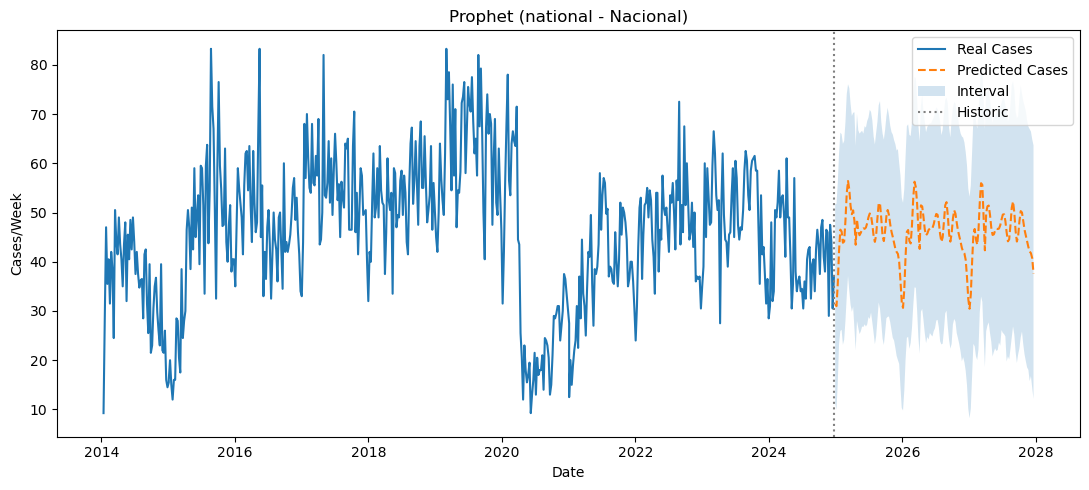

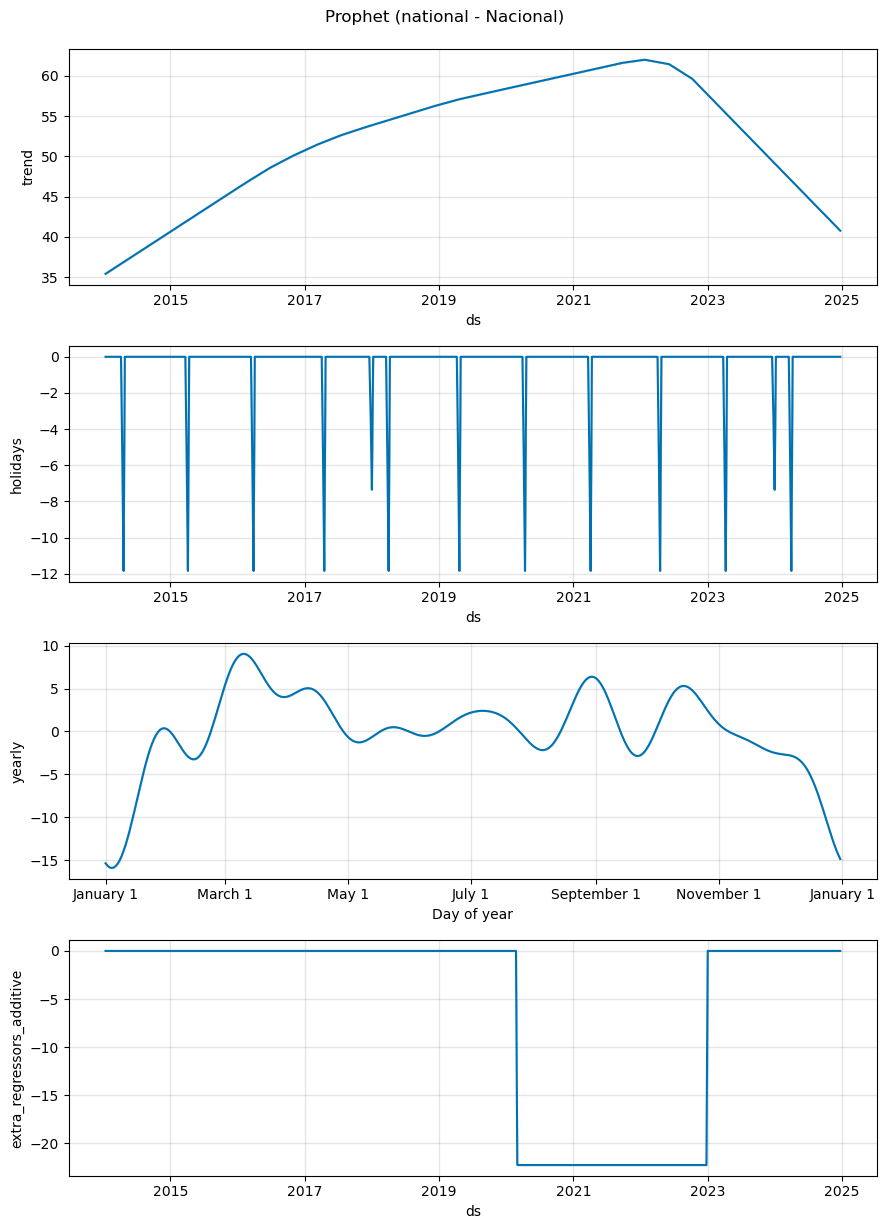

16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1]

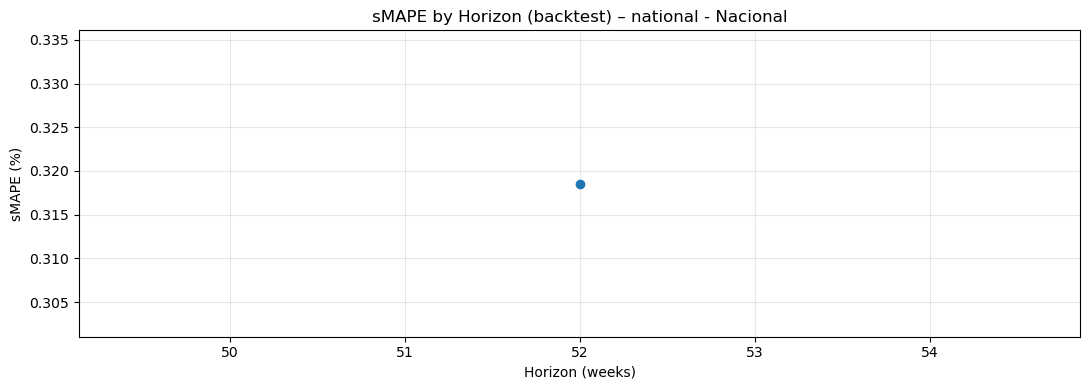

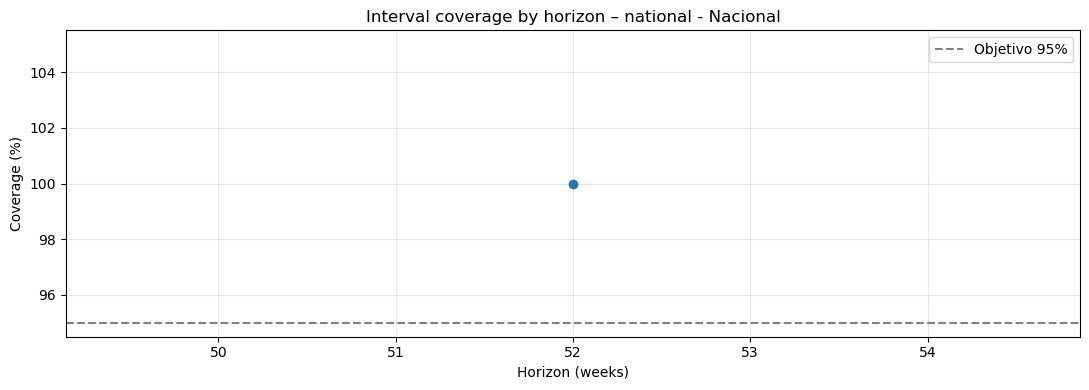

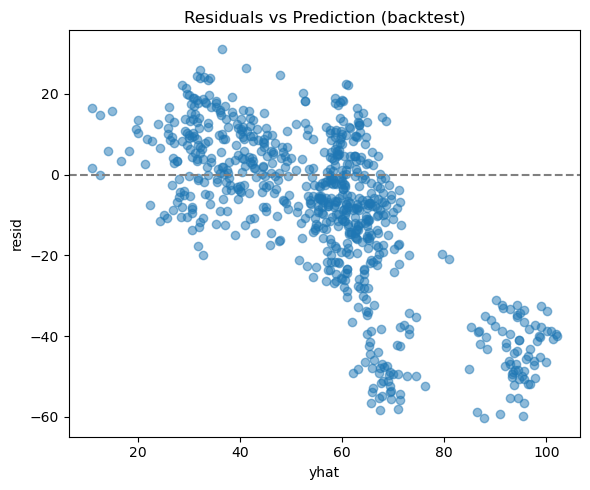

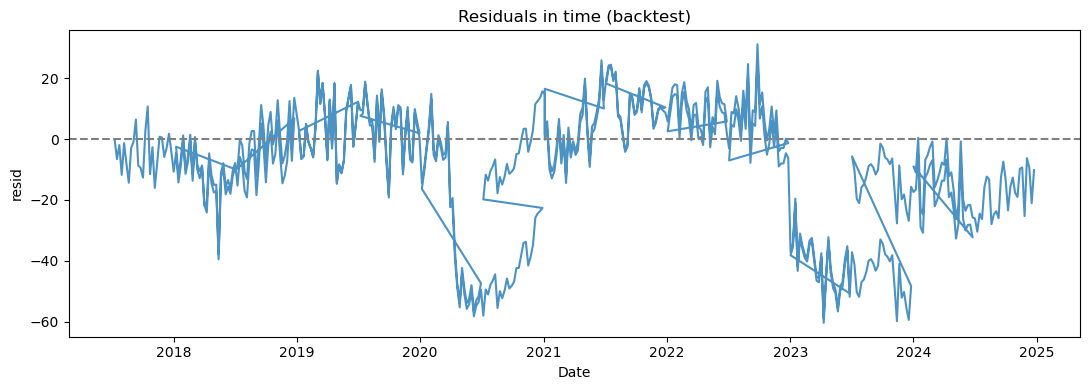

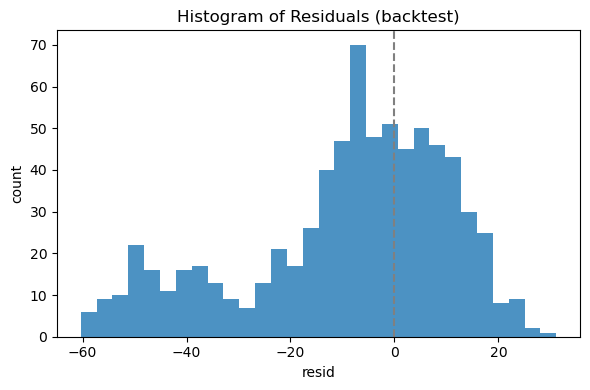

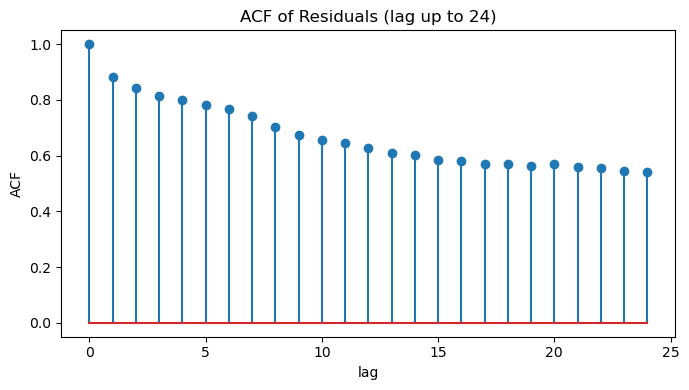

16:33:51 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1] done processing
16:33:51 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1] done processing
16:33:51 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1] done processing
16:33:51 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1] done processing
16:33:51 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1] done processing
16:33:51 - cmdstanpy - INFO - Chain [1] done processing
16:33:51 - cmdstanpy - INFO - Chain [1] done processing
16:33:51 - cmdstanpy - INFO - Chain [1] done processing
16:33:51 - cmdstanpy - INFO - Chain [1]

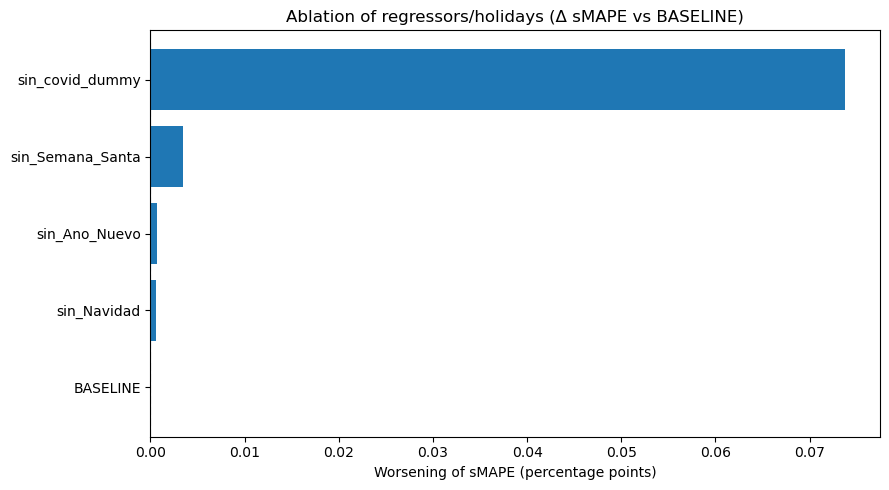

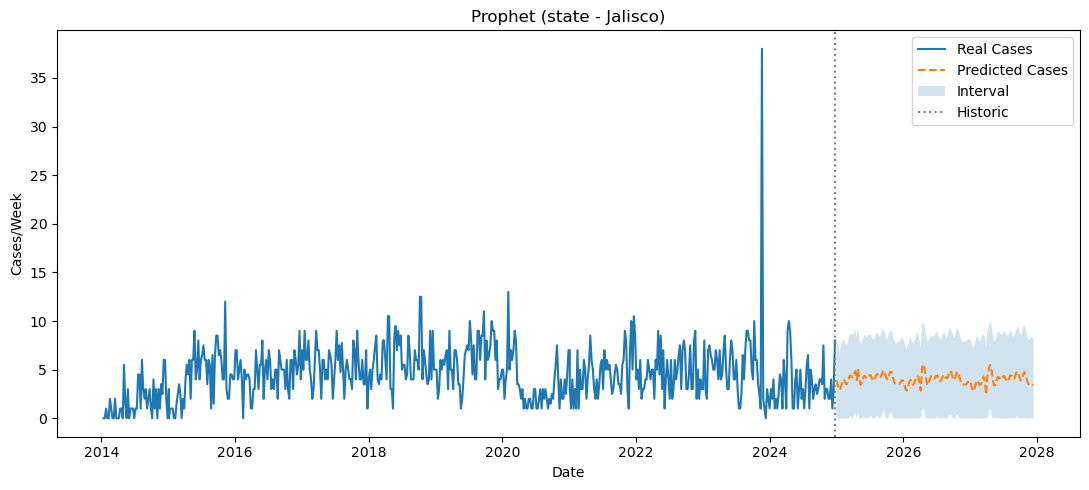

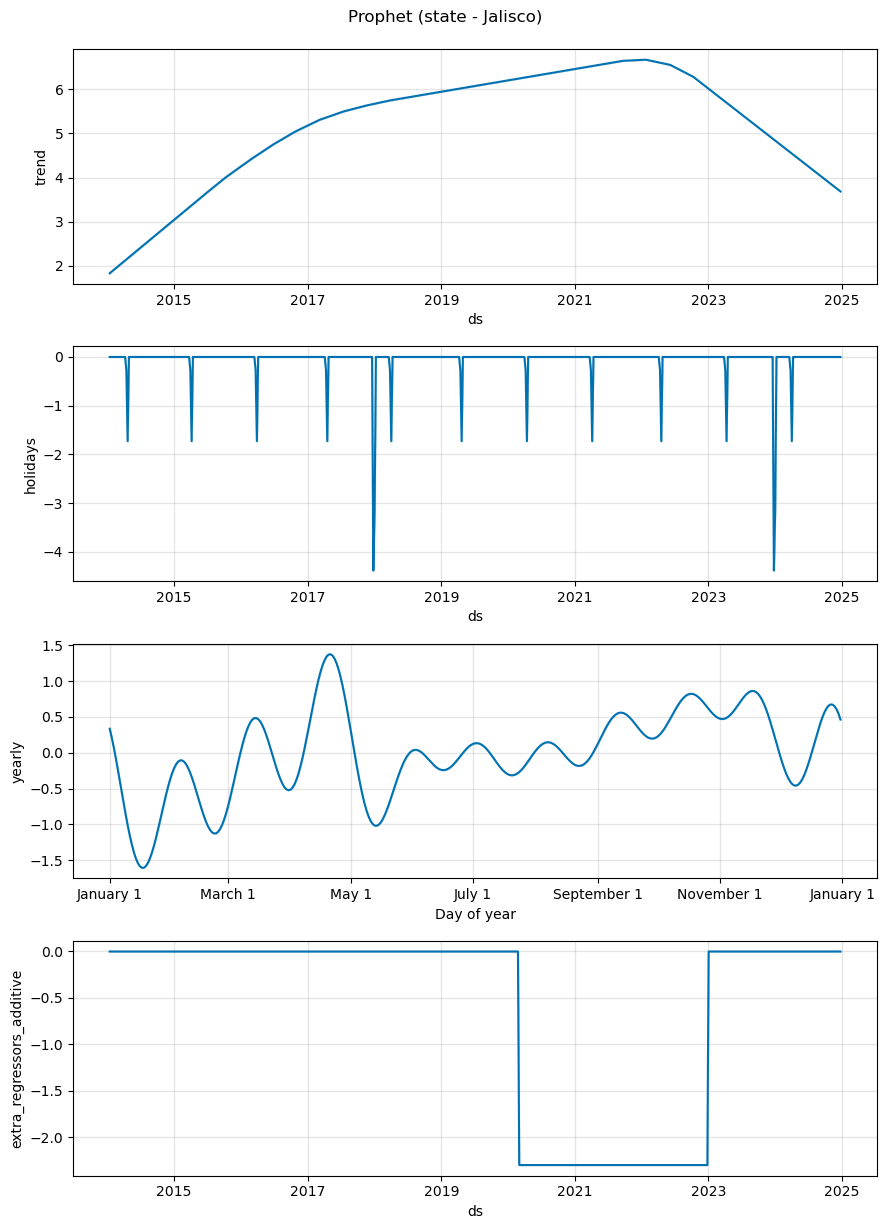

16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1]

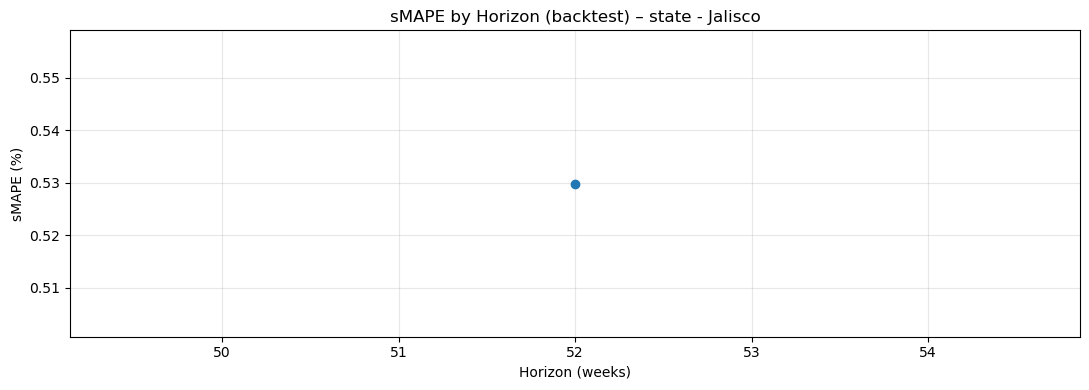

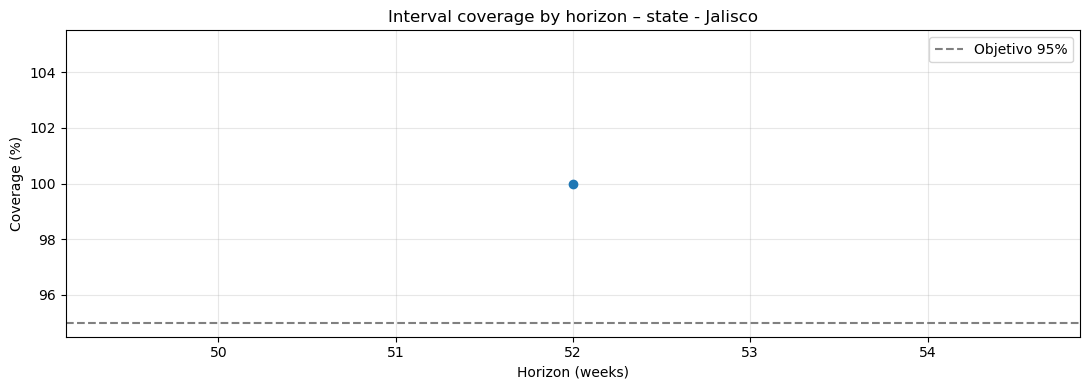

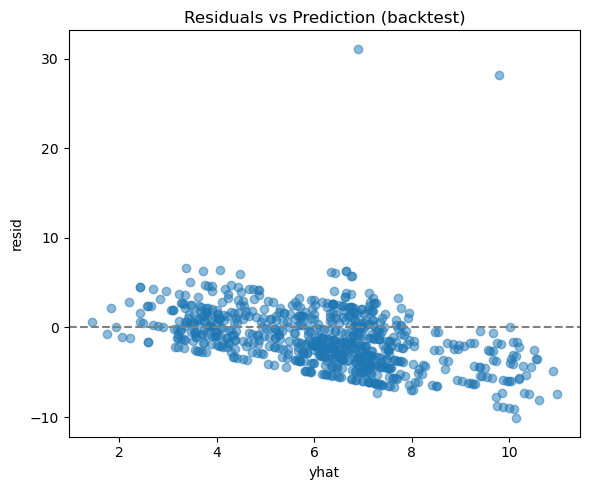

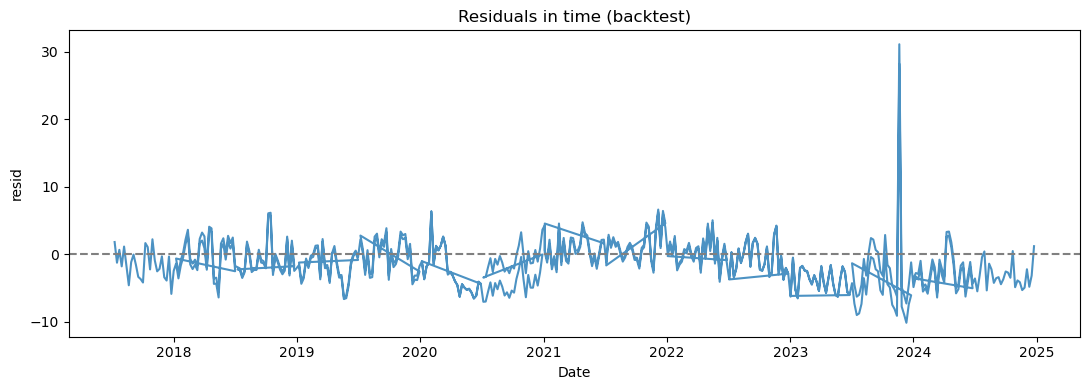

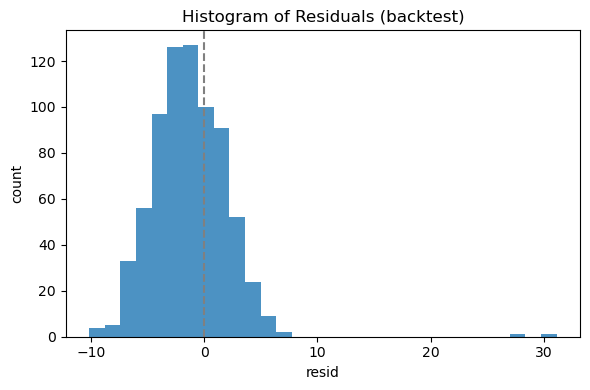

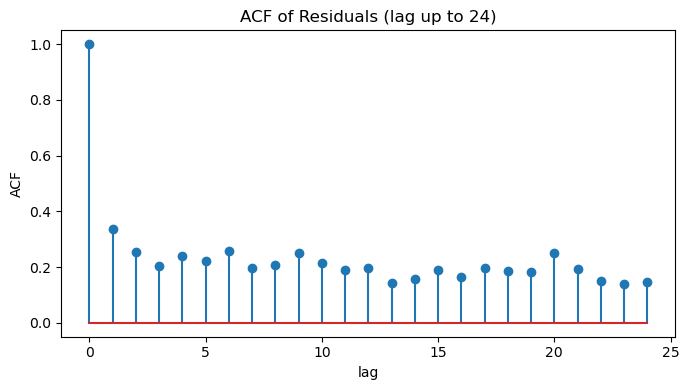

In [1036]:
plot_forecast_future(res, df_national, dfs_state,dfs_state_sex, level="national")
plot_components_for_series(res, df_national, dfs_state,dfs_state_sex, holidays=res["holidays"])
cv_nat, perf_nat = backtest_plots(res, df_national, dfs_state, dfs_state_sex, holidays=res["holidays"])
residual_diagnostics(cv_nat)
ablation_importance(df_national, res["national"]["params"], res["holidays"])

choosen_state = "Jalisco"
plot_forecast_future(res, df_national, dfs_state,dfs_state_sex, level="state", geo=choosen_state)
plot_components_for_series(res, df_national, dfs_state, dfs_state_sex,holidays=res["holidays"], level="state", geo=choosen_state)
cv_st, perf_st = backtest_plots(res, df_national, dfs_state, dfs_state_sex, holidays=res["holidays"], level="state", geo=choosen_state)
residual_diagnostics(cv_st)

# plot_forecast_future(res, df_national, dfs_state,dfs_state_sex, level="states_sex", geo=choosen_state, sex="M")
# plot_components_for_series(res, df_national, dfs_state, dfs_state_sex,holidays=res["holidays"], level="states_sex", geo=choosen_state, sex="M")
# cv_ss, perf_ss = backtest_plots(res, df_national, dfs_state, dfs_state_sex,holidays=res["holidays"], level="states_sex", geo=choosen_state, sex="M")
# residual_diagnostics(cv_ss)